In [1]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

In [2]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp

In [3]:
DATA_DIR = '/kaggle/input/camvid/CamVid'

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_labels')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_labels')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_labels')

In [4]:
class_dict = pd.read_csv("/kaggle/input/camvid/CamVid/class_dict.csv")
# Get class names
class_names = class_dict['name'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone', 'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall']
Class RGB values:  [[64, 128, 64], [192, 0, 128], [0, 128, 192], [0, 128, 64], [128, 0, 0], [64, 0, 128], [64, 0, 192], [192, 128, 64], [192, 192, 128], [64, 64, 128], [128, 0, 192], [192, 0, 64], [128, 128, 64], [192, 0, 192], [128, 64, 64], [64, 192, 128], [64, 64, 0], [128, 64, 128], [128, 128, 192], [0, 0, 192], [192, 128, 128], [128, 128, 128], [64, 128, 192], [0, 0, 64], [0, 64, 64], [192, 64, 128], [128, 128, 0], [192, 128, 192], [64, 0, 64], [192, 192, 0], [0, 0, 0], [64, 192, 0]]


In [5]:
select_classes = ['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone', 'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall']

# Get indices of the selected classes
select_class_indices = [class_names.index(cls) for cls in select_classes]

# Get RGB values for the selected classes
select_class_rgb_values = np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
for cls, rgb in zip(select_classes, select_class_rgb_values):
    print(f"{cls}: {rgb}")

Selected classes and their corresponding RGB values in labels:
Animal: [ 64 128  64]
Archway: [192   0 128]
Bicyclist: [  0 128 192]
Bridge: [  0 128  64]
Building: [128   0   0]
Car: [ 64   0 128]
CartLuggagePram: [ 64   0 192]
Child: [192 128  64]
Column_Pole: [192 192 128]
Fence: [ 64  64 128]
LaneMkgsDriv: [128   0 192]
LaneMkgsNonDriv: [192   0  64]
Misc_Text: [128 128  64]
MotorcycleScooter: [192   0 192]
OtherMoving: [128  64  64]
ParkingBlock: [ 64 192 128]
Pedestrian: [64 64  0]
Road: [128  64 128]
RoadShoulder: [128 128 192]
Sidewalk: [  0   0 192]
SignSymbol: [192 128 128]
Sky: [128 128 128]
SUVPickupTruck: [ 64 128 192]
TrafficCone: [ 0  0 64]
TrafficLight: [ 0 64 64]
Train: [192  64 128]
Tree: [128 128   0]
Truck_Bus: [192 128 192]
Tunnel: [64  0 64]
VegetationMisc: [192 192   0]
Void: [0 0 0]
Wall: [ 64 192   0]


In [6]:
def adjust_mask(mask, flat=False):
    import numpy as np

    semantic_map = []
    for colour in select_class_rgb_values:  # Removed .values() since it's a NumPy array  
        equality = np.equal(mask, colour)  # 256x256x3 with True or False
        class_map = np.all(equality, axis=-1)  # 256x256 If all True, then True, else False
        semantic_map.append(class_map)  # List of 256x256 arrays

    semantic_map = np.stack(semantic_map, axis=-1)  # 256x256x32 with one-hot encoding
    if flat:
        semantic_map = np.reshape(semantic_map, (-1, 256 * 256))

    return np.float32(semantic_map)  # Convert to numbers


In [7]:
def visualize(**images):
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()
    
def one_hot_encode(label, label_values):
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map

def reverse_one_hot(image):
    x = np.argmax(image, axis = -1)
    return x

def colour_code_segmentation(image, label_values):
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [8]:
class RoadsDataset(torch.utils.data.Dataset):
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        
        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):
        
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        
        # one-hot-encode the mask
        mask = adjust_mask(mask).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask

    def __len__(self):
        # return length of 
        return len(self.image_paths)

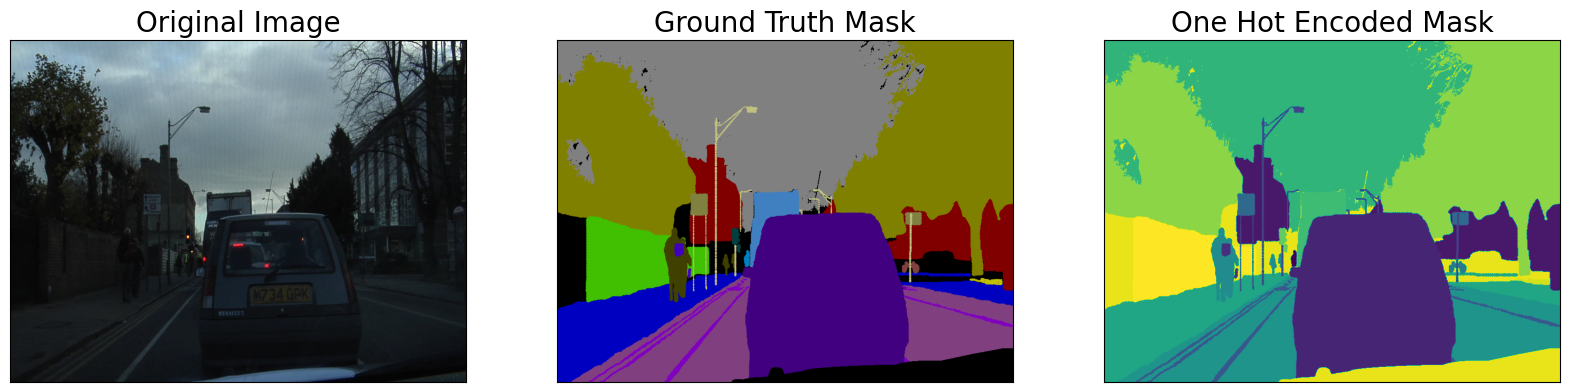

In [9]:
dataset = RoadsDataset(x_train_dir, y_train_dir, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[2]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

In [10]:
def get_training_augmentation():
    train_transform = [    
        album.RandomCrop(height=256, width=256, always_apply=True),
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
            p=0.75,
        ),
    ]
    return album.Compose(train_transform)

def get_validation_augmentation():   
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [
        album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=0),
    ]
    return album.Compose(test_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn=None):
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)

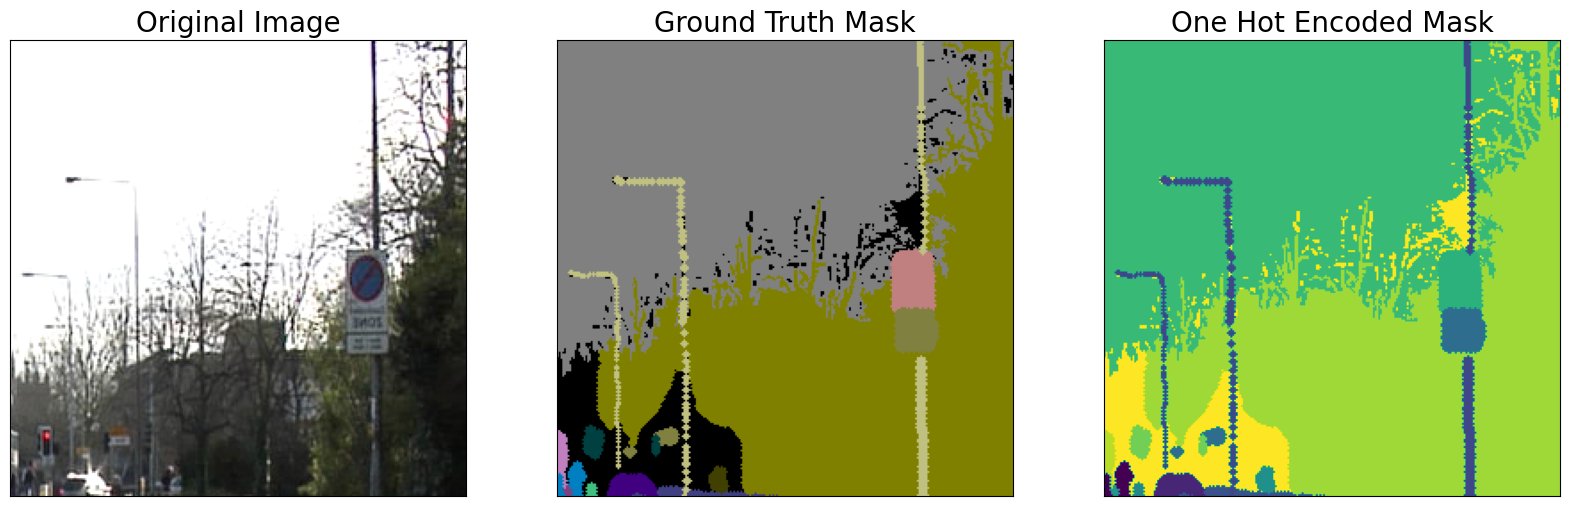

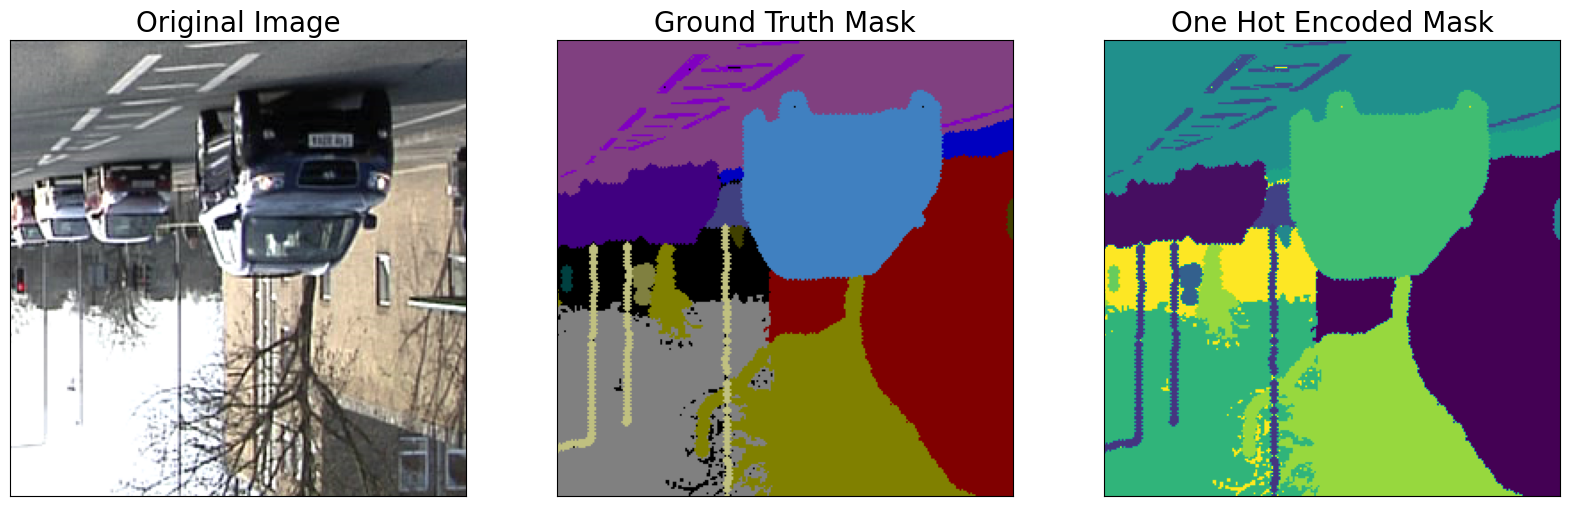

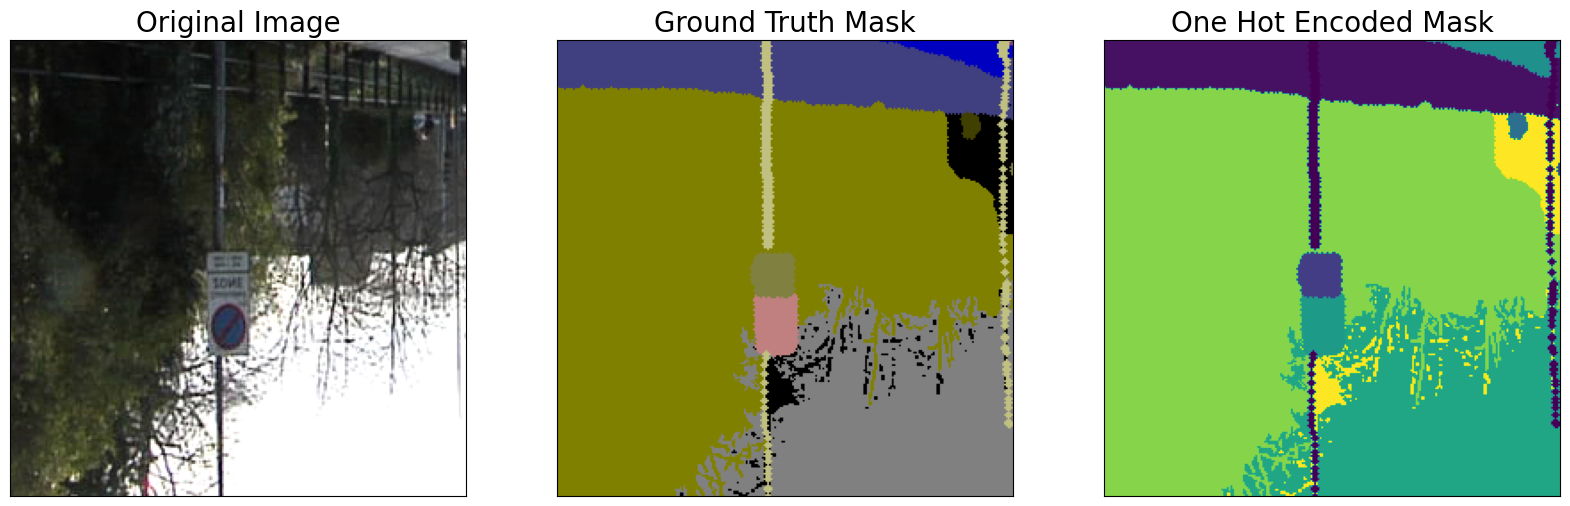

In [11]:
augmented_dataset = RoadsDataset(
    x_train_dir, y_train_dir, 
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset)-1)

# Different augmentations on a random image/mask pair (256*256 crop)
for i in range(3):
    image, mask = augmented_dataset[random_idx]
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )

In [12]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = select_classes
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 170MB/s] 


In [13]:
import albumentations as album

def get_validation_augmentation():
    """
    Apply test-time augmentations (if any).
    Pad to ensure image dimensions are divisible by 32.
    """
    test_transform = [
        album.PadIfNeeded(
            min_height=1536, min_width=1536, 
            always_apply=True, 
            border_mode=0,  # BORDER_CONSTANT
            value=(0, 0, 0)  # Black padding (or choose another color)
        ),
    ]
    return album.Compose(test_transform)

train_dataset = RoadsDataset(
    x_train_dir, y_train_dir, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

valid_dataset = RoadsDataset(
    x_valid_dir, y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

In [14]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.utils.metrics import IoU
import torch
import os


# Define loss function (Fix for AttributeError)
loss = smp.losses.DiceLoss(mode='binary')
loss.__name__ = "DiceLoss"  # Set name to prevent logging issues

# Define metrics
metrics = [
    IoU(threshold=0.5),
]

TRAINING = True

# Set num of epochs
EPOCHS = 30

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.00008),
])

# Define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

# Load best saved model checkpoint from previous commit (if present)
if os.path.exists('../input/unet-resnet50-frontend-road-segmentation-pytorch/best_model.pth'):
    model = torch.load('../input/unet-resnet50-frontend-road-segmentation-pytorch/best_model.pth', map_location=DEVICE)

In [15]:
from segmentation_models_pytorch.utils.train import TrainEpoch, ValidEpoch

class CustomTrainEpoch(TrainEpoch):
    def run(self, dataloader):
        logs = super().run(dataloader)
        # Fix the issue by replacing __name__ with __class__.__name__
        if self.loss.__class__.__name__ not in logs:
            logs[self.loss.__class__.__name__] = logs.pop(self.loss.__name__, None)  # Avoid KeyError
        return logs

train_epoch = CustomTrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [16]:
if TRAINING:
    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):
        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better validation IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model.state_dict(), './best_model.pth')
            print('Model saved!')


Epoch: 0
valid: 100%|██████████| 100/100 [02:24<00:00,  1.45s/it, DiceLoss - 0.9805, iou_score - 0.0162]
Model saved!

Epoch: 1
valid: 100%|██████████| 100/100 [02:21<00:00,  1.42s/it, DiceLoss - 0.9803, iou_score - 0.01553]

Epoch: 2
valid: 100%|██████████| 100/100 [02:20<00:00,  1.41s/it, DiceLoss - 0.9799, iou_score - 0.03518]
Model saved!

Epoch: 3
valid: 100%|██████████| 100/100 [02:20<00:00,  1.40s/it, DiceLoss - 0.98, iou_score - 0.0221]  

Epoch: 4
valid: 100%|██████████| 100/100 [02:21<00:00,  1.41s/it, DiceLoss - 0.9793, iou_score - 0.05984]
Model saved!

Epoch: 5
valid: 100%|██████████| 100/100 [02:19<00:00,  1.40s/it, DiceLoss - 0.9793, iou_score - 0.07457]
Model saved!

Epoch: 6
valid: 100%|██████████| 100/100 [02:21<00:00,  1.41s/it, DiceLoss - 0.9789, iou_score - 0.08667]
Model saved!

Epoch: 7
valid: 100%|██████████| 100/100 [02:22<00:00,  1.42s/it, DiceLoss - 0.979, iou_score - 0.06493]

Epoch: 8
valid: 100%|██████████| 100/100 [02:20<00:00,  1.41s/it, DiceLoss - 0.97

In [17]:
if os.path.exists('./best_model.pth'):
    best_model = torch.load('./best_model.pth', map_location=DEVICE)
    print('Loaded UNet model from this run.')

# load best saved model checkpoint from previous commit (if present)
elif os.path.exists('../input/unet-resnet50-frontend-road-segmentation-pytorch/best_model.pth'):
    best_model = torch.load('../input/unet-resnet50-frontend-road-segmentation-pytorch/best_model.pth', map_location=DEVICE)
    print('Loaded UNet model from a previous commit.')

Loaded UNet model from this run.


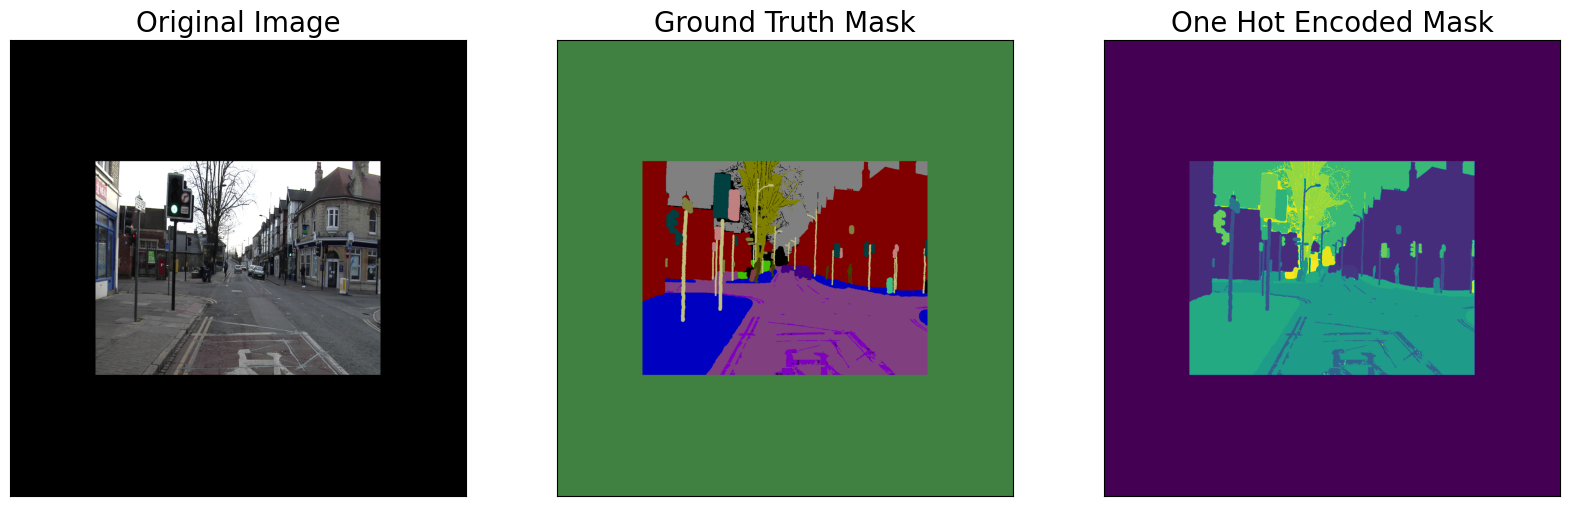

In [18]:
test_dataset = RoadsDataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

# test dataset for visualization (without preprocessing transformations)
test_dataset_vis = RoadsDataset(
    x_test_dir, y_test_dir, 
    augmentation=get_validation_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

In [19]:
def crop_image(image, target_image_dims=[1500,1500,3]):
   
    target_size = target_image_dims[0]
    image_size = len(image)
    padding = (image_size - target_size) // 2

    if padding<0:
        return image

    return image[
        padding:image_size - padding,
        padding:image_size - padding,
        :,
    ]

In [20]:
sample_preds_folder = 'sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

In [21]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['DiceLoss']:.4f}")


valid: 100%|██████████| 232/232 [12:02<00:00,  3.11s/it, DiceLoss - 0.9779, iou_score - 0.06615]
Evaluation on Test Data: 
Mean IoU Score: 0.0662
Mean Dice Loss: 0.9779


In [22]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T
valid_logs_df.T

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
DiceLoss,0.980530,0.980301,0.979878,0.979982,0.979338,0.979281,0.978854,0.979030,0.978894,0.978543,...,0.976668,0.976583,0.976495,0.976615,0.976352,0.976362,0.977033,0.977357,0.976570,0.977773
iou_score,0.016196,0.015527,0.035176,0.022100,0.059836,0.074571,0.086673,0.064932,0.052267,0.077427,...,0.105965,0.121390,0.096703,0.121210,0.108048,0.106620,0.079848,0.081284,0.093087,0.068039


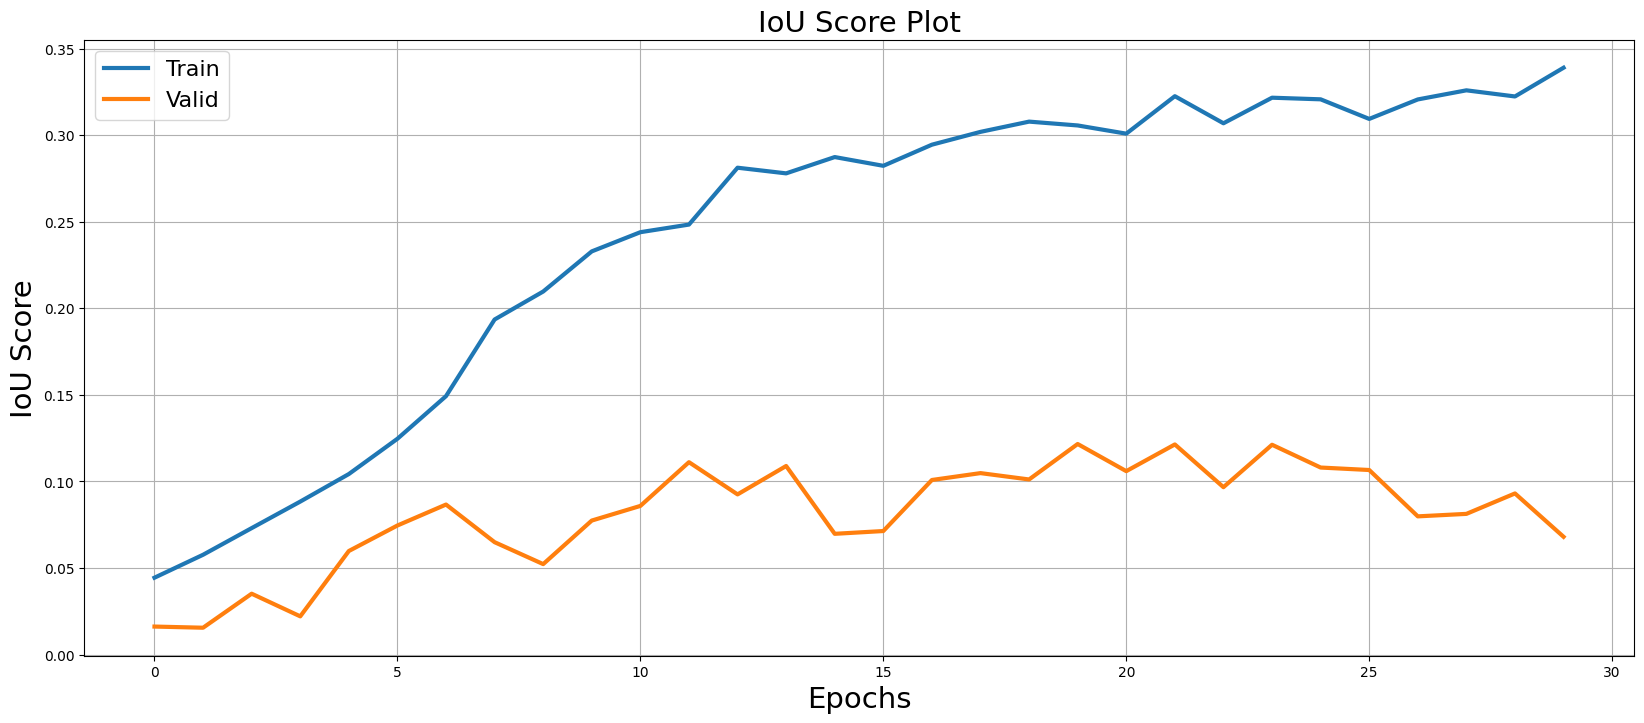

In [23]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=21)
plt.ylabel('IoU Score', fontsize=21)
plt.title('IoU Score Plot', fontsize=21)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

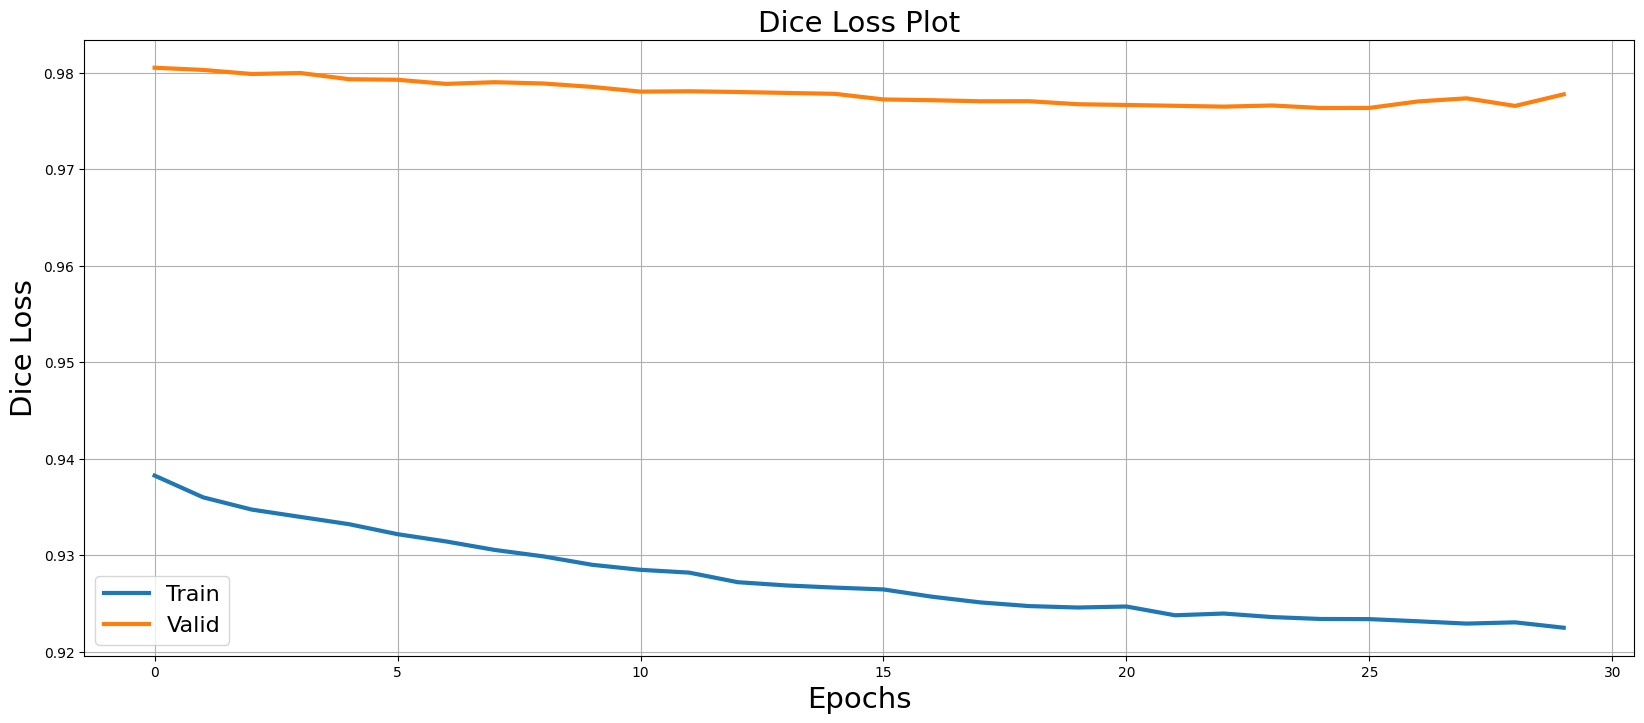

In [24]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.DiceLoss.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.DiceLoss.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=21)
plt.ylabel('Dice Loss', fontsize=21)
plt.title('Dice Loss Plot', fontsize=21)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('dice_loss_plot.png')
plt.show()

In [25]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = select_classes
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [26]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.utils.metrics import IoU
import torch
import os


# Define loss function (Fix for AttributeError)
loss = smp.losses.DiceLoss(mode='binary')
loss.__name__ = "DiceLoss"  # Set name to prevent logging issues

# Define metrics
metrics = [
    IoU(threshold=0.5),
]

TRAINING = True

# Set num of epochs
EPOCHS = 20

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.00008),
])

# Define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

# Load best saved model checkpoint from previous commit (if present)
if os.path.exists('../input/unet-resnet50-frontend-road-segmentation-pytorch/best_modelfcn.pth'):
    model = torch.load('../input/unet-resnet50-frontend-road-segmentation-pytorch/best_modelfcn.pth', map_location=DEVICE)

In [27]:
from segmentation_models_pytorch.utils.train import TrainEpoch, ValidEpoch

class CustomTrainEpoch(TrainEpoch):
    def run(self, dataloader):
        logs = super().run(dataloader)
        # Fix the issue by replacing __name__ with __class__.__name__
        if self.loss.__class__.__name__ not in logs:
            logs[self.loss.__class__.__name__] = logs.pop(self.loss.__name__, None)  # Avoid KeyError
        return logs

train_epoch = CustomTrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [28]:
if TRAINING:
    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):
        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better validation IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model.state_dict(), './best_modelfcn.pth')
            print('Model saved!')


Epoch: 0
valid: 100%|██████████| 100/100 [02:18<00:00,  1.38s/it, DiceLoss - 0.9774, iou_score - 0.03414]
Model saved!

Epoch: 1
valid: 100%|██████████| 100/100 [02:18<00:00,  1.39s/it, DiceLoss - 0.9765, iou_score - 0.05257]
Model saved!

Epoch: 2
valid: 100%|██████████| 100/100 [02:17<00:00,  1.37s/it, DiceLoss - 0.9759, iou_score - 0.06854]
Model saved!

Epoch: 3
valid: 100%|██████████| 100/100 [02:17<00:00,  1.38s/it, DiceLoss - 0.9759, iou_score - 0.06929]
Model saved!

Epoch: 4
valid: 100%|██████████| 100/100 [02:17<00:00,  1.37s/it, DiceLoss - 0.9757, iou_score - 0.07138]
Model saved!

Epoch: 5
valid: 100%|██████████| 100/100 [02:17<00:00,  1.37s/it, DiceLoss - 0.9755, iou_score - 0.08605]
Model saved!

Epoch: 6
valid: 100%|██████████| 100/100 [02:18<00:00,  1.39s/it, DiceLoss - 0.9754, iou_score - 0.09031]
Model saved!

Epoch: 7
valid: 100%|██████████| 100/100 [02:18<00:00,  1.38s/it, DiceLoss - 0.9754, iou_score - 0.09178]
Model saved!

Epoch: 8
valid: 100%|██████████| 100/10

In [29]:
if os.path.exists('./best_modelfcn.pth'):
    best_model = torch.load('./best_modelfcn.pth', map_location=DEVICE)
    print('Loaded UNet model from this run.')

# load best saved model checkpoint from previous commit (if present)
elif os.path.exists('../input/unet-resnet50-frontend-road-segmentation-pytorch/best_modelfcn.pth'):
    best_model = torch.load('../input/unet-resnet50-frontend-road-segmentation-pytorch/best_modelfcn.pth', map_location=DEVICE)
    print('Loaded FCN model from a previous commit.')

Loaded UNet model from this run.


In [30]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['DiceLoss']:.4f}")

valid: 100%|██████████| 232/232 [11:40<00:00,  3.02s/it, DiceLoss - 0.9749, iou_score - 0.1925]
Evaluation on Test Data: 
Mean IoU Score: 0.1925
Mean Dice Loss: 0.9749


In [31]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
DiceLoss,0.932012,0.925844,0.924075,0.923194,0.922756,0.922335,0.921215,0.921193,0.920901,0.920961,0.920847,0.920608,0.920127,0.919956,0.920195,0.919718,0.919762,0.919471,0.919171,0.919537
iou_score,0.063483,0.118926,0.159024,0.181110,0.190158,0.207470,0.234719,0.242898,0.252581,0.250970,0.257002,0.270778,0.303499,0.312942,0.310302,0.337306,0.355335,0.358473,0.393925,0.368174


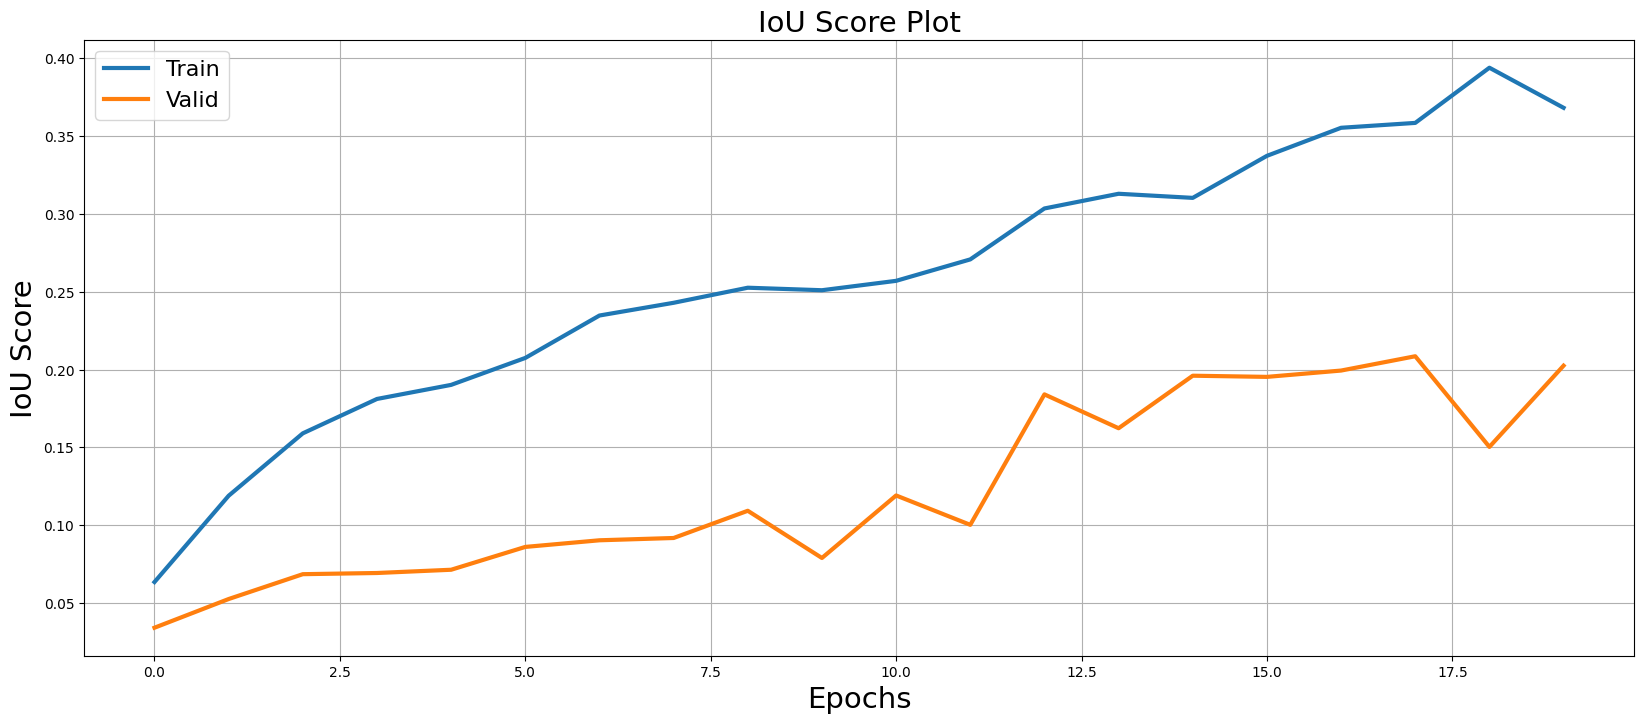

In [32]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=21)
plt.ylabel('IoU Score', fontsize=21)
plt.title('IoU Score Plot', fontsize=21)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

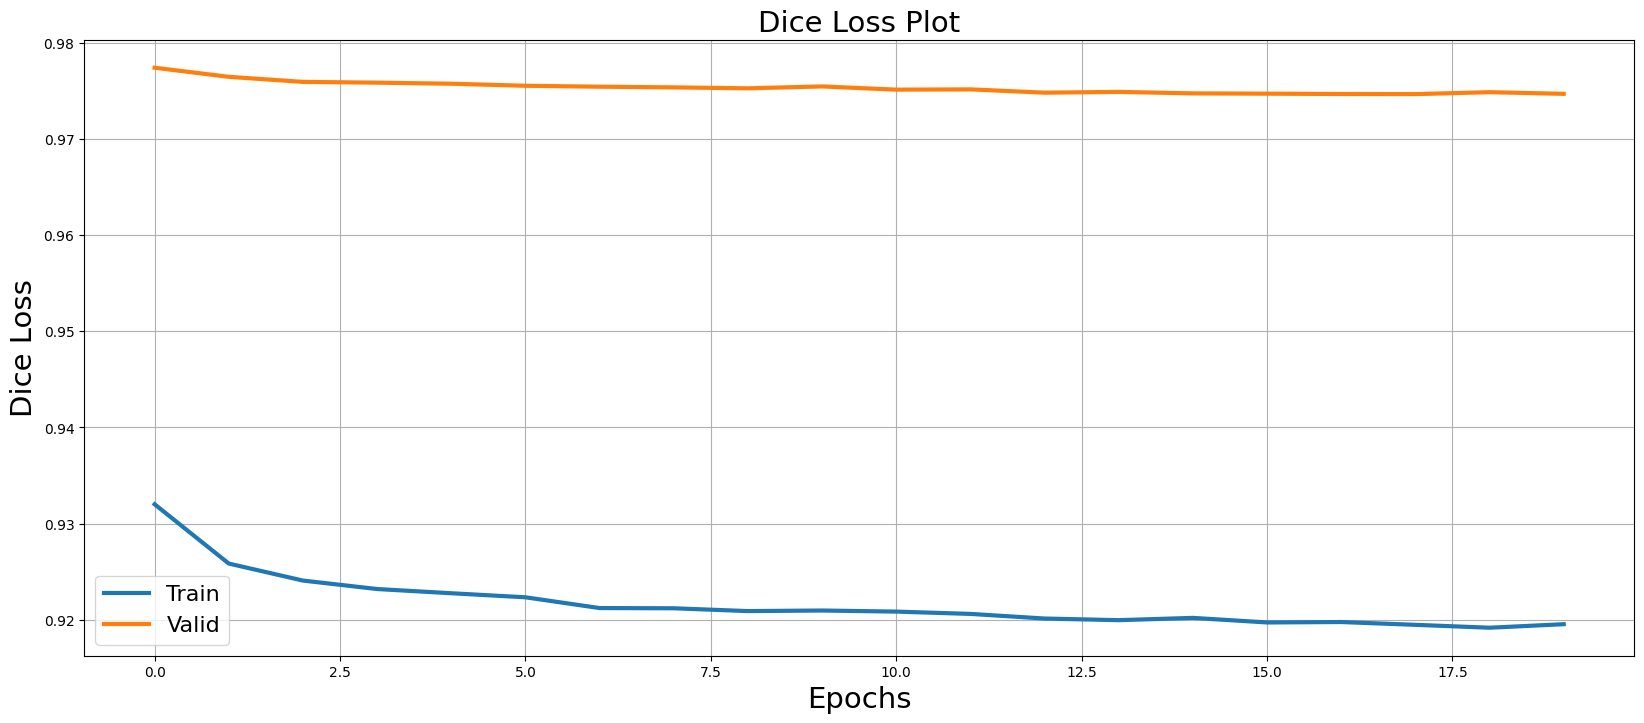

In [33]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.DiceLoss.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.DiceLoss.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=21)
plt.ylabel('Dice Loss', fontsize=21)
plt.title('Dice Loss Plot', fontsize=21)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('dice_loss_plot.png')
plt.show()